<a href="https://colab.research.google.com/github/thanhcong227/Thesis/blob/main/Unetr_btcv_segmentation_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)


This tutorial demonstrates how to construct a training workflow of UNETR [1] on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm.

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kidney 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from:


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including:
1. large organs: spleen, liver, stomach.
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas.
3. Vascular tissues: aorta, IVC, P&S Veins.
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1]:

[1]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb)

## Setup environment

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00


## Setup imports

In [ ]:
!pip install "monai[einops]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.7.0
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp0s6p1w5d


## Setup transforms for training and validation

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

In [ ]:
# uncomment this command to download the JSON file directly
# wget -O data/dataset_0.json 'https://drive.google.com/uc?export=download&id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi'
!mkdir -p data
!wget "https://drive.google.com/uc?export=download&id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi" -O data/dataset_0.json

--2024-03-08 07:31:49--  https://drive.google.com/uc?export=download&id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi
Resolving drive.google.com (drive.google.com)... 74.125.143.138, 74.125.143.101, 74.125.143.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi&export=download [following]
--2024-03-08 07:31:49--  https://drive.usercontent.google.com/download?id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.18.132, 2a00:1450:4013:c18::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.18.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4910 (4.8K) [application/octet-stream]
Saving to: ‘data/dataset_0.json’

data/dataset_0.json 100%[===================>]   4.79K  --.-KB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p data/imagesTr
!mkdir -p data/labelsTr
!mkdir -p copydata

In [ ]:
!cp "/content/drive/MyDrive/RawData.rar" "/content"
!unrar x "/content/RawData.rar"  "/content/copydata"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/RawData.rar

Creating    /content/copydata/RawData                                 OK
Creating    /content/copydata/RawData/Testing                         OK
Creating    /content/copydata/RawData/Testing/img                     OK
Creating    /content/copydata/RawData/Testing/img/img0061.nii         OK
Extracting  /content/copydata/RawData/Testing/img/img0061.nii/img0061.nii.gz       0%  1%  2%  OK 
Creating    /content/copydata/RawData/Testing/img/img0062.nii         OK
Extracting  /content/copydata/RawData/Testing/img/img0062.nii/img0062.nii.gz       2%  3%  OK 
Creating    /content/copydata/RawData/Testing/img/img0063.nii         OK
Extracting  /content/copydata/RawData/Testing/img/img0063.nii/img0063.nii.gz       3%  4%  5%  OK 
Creating    /content/copydata/RawData/Testing/img/img0064.nii         OK
Extracting  /content/copydata/RawDa

In [ ]:
import os
import shutil

# Đường dẫn của thư mục img
img_dir = '/content/copydata/RawData/Training/img'

# Duyệt qua từng thư mục con trong thư mục img
for root, dirs, files in os.walk(img_dir):
    for subdir in dirs:
        subdir_path = os.path.join(root, subdir)
        # Kiểm tra xem thư mục con có đuôi .nii không
        if subdir.endswith('.nii'):
            # Di chuyển tất cả các tệp có đuôi .gz đến thư mục img
            for file in os.listdir(subdir_path):
                if file.endswith('.gz'):
                    shutil.move(os.path.join(subdir_path, file), img_dir)
            # Xóa thư mục có đuôi .nii
            shutil.rmtree(subdir_path)

In [ ]:
import os
import shutil

# Đường dẫn của thư mục img
img_dir = '/content/copydata/RawData/Training/label'

# Duyệt qua từng thư mục con trong thư mục img
for root, dirs, files in os.walk(img_dir):
    for subdir in dirs:
        subdir_path = os.path.join(root, subdir)
        # Kiểm tra xem thư mục con có đuôi .nii không
        if subdir.endswith('.nii'):
            # Di chuyển tất cả các tệp có đuôi .gz đến thư mục img
            for file in os.listdir(subdir_path):
                if file.endswith('.gz'):
                    shutil.move(os.path.join(subdir_path, file), img_dir)
            # Xóa thư mục có đuôi .nii
            shutil.rmtree(subdir_path)

In [ ]:
!mv /content/copydata/RawData/Training/img/* /content/data/imagesTr
!mv /content/copydata/RawData/Training/label/* /content/data/labelsTr

In [ ]:
data_dir = "/content/data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 24/24 [02:02<00:00,  5.09s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 6/6 [00:34<00:00,  5.79s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid

## Check data shape and visualize

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


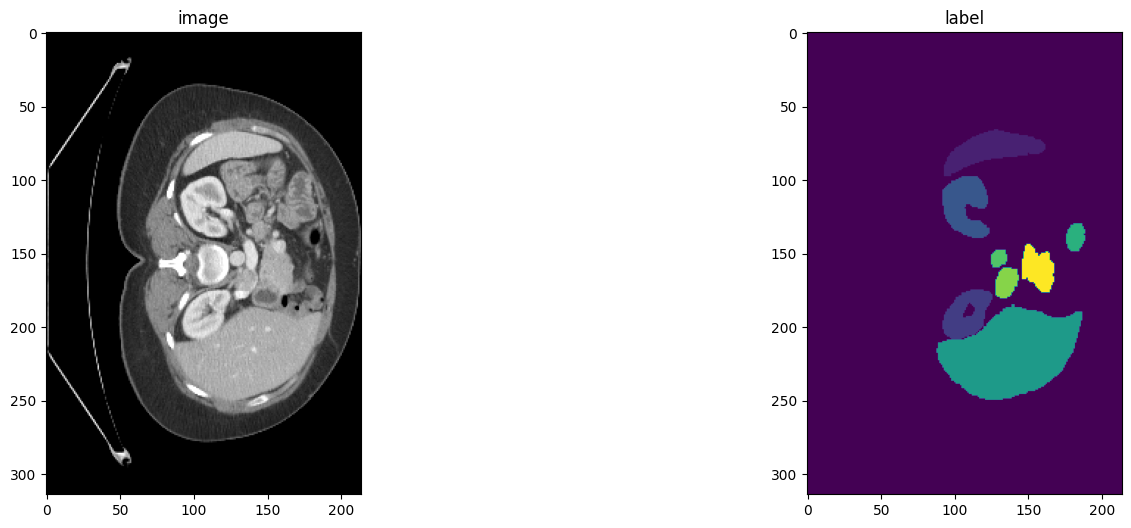

In [ ]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    conv_block=True,
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


### Execute a typical PyTorch training process

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/24 [00:03<?, ?it/s]
Exception in thread Thread-38 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 355, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _

KeyboardInterrupt: 

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

In [ ]:
print(model)


In [ ]:
import monai
print(monai.__version__)

1.3.0


In [ ]:
import torch

# Đường dẫn đến tệp trọng số
weight_file_path = "/content/drive/MyDrive/UNETR_model_best_acc.pth"

# Tải trọng số vào một đối tượng OrderedDict
weights = torch.load(weight_file_path, map_location=torch.device('cpu'))

# In ra các khóa của trọng số và các kích thước của các trọng số
for key in weights:
    print(key, weights[key].size())


vit.patch_embedding.position_embeddings torch.Size([1, 216, 768])
vit.patch_embedding.cls_token torch.Size([1, 1, 768])
vit.patch_embedding.patch_embeddings.1.weight torch.Size([768, 4096])
vit.patch_embedding.patch_embeddings.1.bias torch.Size([768])
vit.blocks.0.mlp.linear1.weight torch.Size([3072, 768])
vit.blocks.0.mlp.linear1.bias torch.Size([3072])
vit.blocks.0.mlp.linear2.weight torch.Size([768, 3072])
vit.blocks.0.mlp.linear2.bias torch.Size([768])
vit.blocks.0.norm1.weight torch.Size([768])
vit.blocks.0.norm1.bias torch.Size([768])
vit.blocks.0.attn.out_proj.weight torch.Size([768, 768])
vit.blocks.0.attn.out_proj.bias torch.Size([768])
vit.blocks.0.attn.qkv.weight torch.Size([2304, 768])
vit.blocks.0.norm2.weight torch.Size([768])
vit.blocks.0.norm2.bias torch.Size([768])
vit.blocks.1.mlp.linear1.weight torch.Size([3072, 768])
vit.blocks.1.mlp.linear1.bias torch.Size([3072])
vit.blocks.1.mlp.linear2.weight torch.Size([768, 3072])
vit.blocks.1.mlp.linear2.bias torch.Size([768]

In [ ]:
import torch

# Đường dẫn đến tệp trọng số
weight_file_path = "/content/drive/MyDrive/UNETR_model_best_acc.pth"

# Tải trọng số vào một đối tượng OrderedDict
weights = torch.load(weight_file_path, map_location=torch.device('cpu'))

keys_to_remove = ["vit.patch_embedding.cls_token", "encoder2.blocks.0.1.conv3.conv.weight", "encoder2.blocks.1.1.conv3.conv.weight", "encoder3.blocks.0.1.conv3.conv.weight"]

for key in keys_to_remove:
  weights.pop(key, None)

model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/UNETR_model_best_acc.pt")["state_dict"])
model.eval()

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b

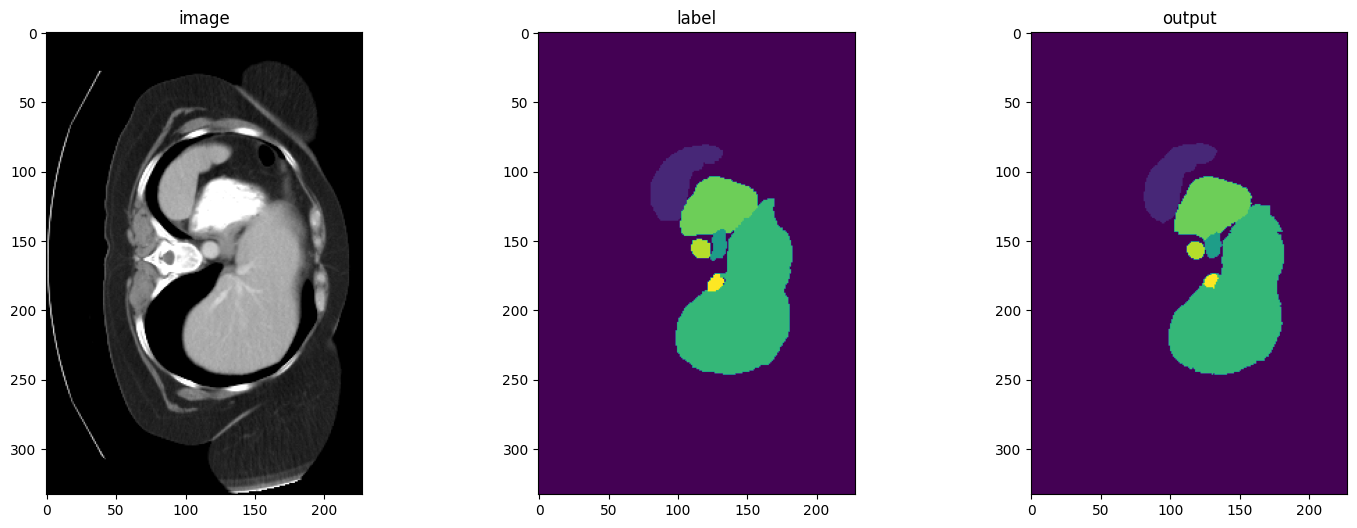

In [ ]:
case_num = 4
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.5)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [ ]:
print(val_labels.view(-1))
print(len(val_inputs.view(-1)))
print(len(val_labels.view(-1)))

metatensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
17006976
17006976


In [ ]:
import argparse
import os

import nibabel as nib
import numpy as np
import torch
from monai import data, transforms
import scipy.ndimage as ndimage
import math

from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR

def resample_3d(img, target_size):
    imx, imy, imz = img.shape
    tx, ty, tz = target_size
    zoom_ratio = (float(tx) / float(imx), float(ty) / float(imy), float(tz) / float(imz))
    img_resampled = ndimage.zoom(img, zoom_ratio, order=0, prefilter=False)
    return img_resampled


def dice(x, y):
    intersect = np.sum(np.sum(np.sum(x * y)))
    y_sum = np.sum(np.sum(np.sum(y)))
    if y_sum == 0:
        return 0.0
    x_sum = np.sum(np.sum(np.sum(x)))
    return 2 * intersect / (x_sum + y_sum)

class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, num_replicas=None, rank=None, shuffle=True, make_even=True):
        if num_replicas is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = torch.distributed.get_world_size()
        if rank is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = torch.distributed.get_rank()
        self.shuffle = shuffle
        self.make_even = make_even
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(len(self.dataset) * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        indices = list(range(len(self.dataset)))
        self.valid_length = len(indices[self.rank : self.total_size : self.num_replicas])

    def __iter__(self):
        if self.shuffle:
            g = torch.Generator()
            g.manual_seed(self.epoch)
            indices = torch.randperm(len(self.dataset), generator=g).tolist()
        else:
            indices = list(range(len(self.dataset)))
        if self.make_even:
            if len(indices) < self.total_size:
                if self.total_size - len(indices) < len(indices):
                    indices += indices[: (self.total_size - len(indices))]
                else:
                    extra_ids = np.random.randint(low=0, high=len(indices), size=self.total_size - len(indices))
                    indices += [indices[ids] for ids in extra_ids]
            assert len(indices) == self.total_size
        indices = indices[self.rank : self.total_size : self.num_replicas]
        self.num_samples = len(indices)
        return iter(indices)

    def __len__(self):
        return self.num_samples

    def set_epoch(self, epoch):
        self.epoch = epoch

def get_loader(args):
    data_dir = args.data_dir
    datalist_json = os.path.join(data_dir, args.json_list)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.AddChanneld(keys=["image", "label"]),
            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.Spacingd(
                keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
            ),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(args.roi_x, args.roi_y, args.roi_z),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=2),
            transforms.RandRotate90d(keys=["image", "label"], prob=args.RandRotate90d_prob, max_k=3),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=args.RandScaleIntensityd_prob),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=args.RandShiftIntensityd_prob),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.AddChanneld(keys=["image", "label"]),
            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.Spacingd(
                keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
            ),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.AddChanneld(keys=["image", "label"]),
            # transforms.Orientationd(keys=["image"], axcodes="RAS"),
            transforms.Spacingd(keys="image", pixdim=(args.space_x, args.space_y, args.space_z), mode="bilinear"),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    if args.test_mode:
        test_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        test_ds = data.Dataset(data=test_files, transform=test_transform)
        test_sampler = Sampler(test_ds, shuffle=False) if args.distributed else None
        test_loader = data.DataLoader(
            test_ds,
            batch_size=1,
            shuffle=False,
            num_workers=args.workers,
            sampler=test_sampler,
            pin_memory=True,
            persistent_workers=True,
        )
        loader = test_loader
    else:
        datalist = load_decathlon_datalist(datalist_json, True, "training", base_dir=data_dir)
        if args.use_normal_dataset:
            train_ds = data.Dataset(data=datalist, transform=train_transform)
        else:
            train_ds = data.CacheDataset(
                data=datalist, transform=train_transform, cache_num=24, cache_rate=1.0, num_workers=args.workers
            )
        train_sampler = Sampler(train_ds) if args.distributed else None
        train_loader = data.DataLoader(
            train_ds,
            batch_size=args.batch_size,
            shuffle=(train_sampler is None),
            num_workers=args.workers,
            sampler=train_sampler,
            pin_memory=True,
        )
        val_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        val_ds = data.Dataset(data=val_files, transform=val_transform)
        val_sampler = Sampler(val_ds, shuffle=False) if args.distributed else None
        val_loader = data.DataLoader(
            val_ds, batch_size=1, shuffle=False, num_workers=args.workers, sampler=val_sampler, pin_memory=True
        )
        loader = [train_loader, val_loader]

    return loader



In [ ]:
import numpy as np

def dice(x, y):
    intersect = np.sum(np.sum(np.sum(x * y)))
    y_sum = np.sum(np.sum(np.sum(y)))
    if y_sum == 0:
        return 0.0
    x_sum = np.sum(np.sum(np.sum(x)))
    return 2 * intersect / (x_sum + y_sum)

def iou(prediction, ground_truth):
    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score



dice_coefficients = []
iou_coefficients = []

with torch.no_grad():
    for case_num in range(len(val_ds)):
        img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
        img = val_ds[case_num]["image"]
        label = val_ds[case_num]["label"]
        val_inputs = torch.unsqueeze(img, 1).cuda()
        val_labels = torch.unsqueeze(label, 1).cuda()

        _, _, h, w, d = val_labels.shape
        target_shape = (h, w, d)
        val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.5, mode="gaussian")
        val_outputs = torch.softmax(val_outputs, 1).cpu().numpy()
        val_outputs = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
        val_labels = val_labels.cpu().numpy()[0, 0, :, :, :]
        val_outputs = resample_3d(val_outputs, target_shape)

        dice_list_sub = []
        for i in range(1, 14):
            organ_Dice = dice(val_outputs == i, val_labels == i)
            dice_list_sub.append(organ_Dice)
        mean_dice = np.mean(dice_list_sub)
        print("Mean Organ Dice: {}".format(mean_dice))
        dice_coefficients.append(mean_dice)

        iou_list_sub = []
        for i in range(1, 14):
            organ_Iou = iou(val_outputs == i, val_labels == i)
            iou_list_sub.append(organ_Iou)
        mean_iou = np.mean(iou_list_sub)
        print("Mean Organ Iou: {}".format(mean_iou))
        iou_coefficients.append(mean_iou)

    print("Overall Mean Dice: {}".format(np.mean(dice_coefficients)))
    print("Overall Mean Iou: {}".format(np.mean(iou_coefficients)))


Mean Organ Dice: 0.7394783267918785
Mean Organ Iou: 0.631755091068713
Mean Organ Dice: 0.7289886741595122
Mean Organ Iou: 0.5957732809742369
Mean Organ Dice: 0.7741539897764492
Mean Organ Iou: 0.6379521960236144
Mean Organ Dice: 0.7215271675868065
Mean Organ Iou: 0.5936788785741137
Mean Organ Dice: 0.7789069703678487
Mean Organ Iou: 0.6572330496843247
Mean Organ Dice: 0.7500038948711035
Mean Organ Iou: 0.6254906016906756
Overall Mean Dice: 0.7488431705922665
Overall Mean Iou: 0.623647183002613


In [ ]:
print(dice_list_sub)
print(iou_list_sub)

[0.8786069796972837, 0.9023243768209777, 0.9112964562412179, 0.3256997455470738, 0.6256295467263571, 0.9357165916896356, 0.9257307170748443, 0.7033898305084746, 0.7349723259106706, 0.7598627787307033, 0.7610354762794994, 0.6308068459657702, 0.6549789621318373]
[0.7834960301965378, 0.822031898829747, 0.8370473867430791, 0.1945288753799392, 0.4552117263843648, 0.8791987025102281, 0.8617306031073961, 0.5424836601307189, 0.580993080993081, 0.6127247579529738, 0.6142512248810623, 0.4607142857142857, 0.4869655891553702]


### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)